In [32]:
import cv2
import os
import rosbag2_py
import datetime
import json
from io import BytesIO

from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib import gridspec
import pandas as pd
import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from deepracer_interfaces_pkg.msg import InferResultsArray, InferResults
from rclpy.serialization import deserialize_message

from deepracer_viz.gradcam.cam import GradCam
from deepracer_viz.model.model import Model
from deepracer_viz.model.metadata import ModelMetadata


In [33]:
bridge = CvBridge()

In [34]:
def get_rosbag_options(path, serialization_format='cdr'):
    storage_options = rosbag2_py.StorageOptions(uri=path, storage_id='sqlite3')

    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format=serialization_format,
        output_serialization_format=serialization_format)

    return storage_options, converter_options

In [35]:
def create_plot(action_names, height, width, dpi):
   
    fig = plt.figure(figsize=(width/dpi,height/dpi), dpi=dpi)
    x = list(range(0,len(action_names)))

    spec = gridspec.GridSpec(ncols=2, nrows=2,
                            width_ratios=[1, 1], wspace=0.1,
                            hspace=0.1, height_ratios=[3, 1], left=0.05,right=0.95,top=0.99,bottom=0.2)
    ax0 = fig.add_subplot(spec[0])
    plt.setp(ax0, xlabel="Original")
    plt.tick_params(labelleft = False, labelbottom=False)
    ax1 = fig.add_subplot(spec[1])
    plt.setp(ax1, xlabel="GradCam")
    plt.tick_params(labelleft = False, labelbottom=False)

    ax2 = fig.add_subplot(spec[2])
    ax2.set_ylim(0.0, 1.0)
    plt.setp(ax2, xlabel="OpenVINO")
    plt.xticks(x,action_names[::-1],rotation='vertical')

    ax3 = fig.add_subplot(spec[3], sharey=ax2)
    ax3.set_ylim(0.0, 1.0)
    plt.setp(ax3, xlabel="Tensorflow")
    plt.xticks(x,action_names[::-1],rotation='vertical')
    fig.canvas.draw()

    return fig

In [36]:
def update_plot(fig: Figure, step, action_names, img, gradcam):

    x = list(range(0,len(action_names)))

    openvino_result = pd.DataFrame(step['openvino_results'])
    tf_result = pd.DataFrame(step['tf_results'])

    ax = fig.get_axes()

    for a in ax:
        for p in set(a.containers):
            p.remove()
        for i in set(a.images):
            i.remove()

    ax[0].imshow(img)
    ax[1].imshow(gradcam)
    ax[2].bar(x,openvino_result['probability'][::-1], color='blue')
    ax[3].bar(x,tf_result['probability'][::-1], color='blue')
    fig.canvas.draw()

    buf = fig.canvas.buffer_rgba()
    ncols, nrows = fig.canvas.get_width_height()
    return cv2.cvtColor(np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 4), cv2.COLOR_RGBA2BGR)


In [37]:
bag_path = '/workspaces/deepracer-devel/output/reinvent_logs/deepracer-bag-20221130-171332'
metadata_json = '/workspaces/deepracer-devel/output/reinvent_logs/model/model_metadata.json'
model_pb = '/workspaces/deepracer-devel/output/reinvent_logs/model/model.pb'

CODEC = "avc1"
output_file = "/workspaces/deepracer-devel/output/test.mp4"
width = 900
height = 600
fps = 15

In [38]:
storage_options, converter_options = get_rosbag_options(bag_path)

reader = rosbag2_py.SequentialReader()
reader.open(storage_options, converter_options)

metadata = ModelMetadata.from_file(metadata_json)
model = Model.from_file(model_pb_path=model_pb, metadata=metadata)

Device mapping: no known devices.


[INFO] [1674297560.225139625] [rosbag2_storage]: Opened database '/workspaces/deepracer-devel/output/reinvent_logs/deepracer-bag-20221130-171332/deepracer-bag-20221130-171332_0.db3' for READ_ONLY.


In [39]:
storage_filter = rosbag2_py.StorageFilter(topics=['/inference_pkg/rl_results'])
reader.set_filter(storage_filter)

first_stamp = -1
steps_data = {'steps': []}

action_names = []
with open(metadata_json,"r") as jsonin:
    model_metadata=json.load(jsonin)
for action in model_metadata['action_space']:
    action_names.append(str(action['steering_angle'])+ u'\N{DEGREE SIGN}' + " "+"%.1f"%action["speed"])

writer = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*CODEC), fps, (width, height))
fig = create_plot(action_names, height, width, 72)

s = 0

with model.session as sess:

    cam = GradCam(model, model.get_conv_outputs())

    while reader.has_next():
        step = {}
        
        (topic, data, t) = reader.read_next()
        msg = deserialize_message(data, InferResultsArray)

        # Timestamp
        timestamp: float = (msg.images[0].header.stamp.sec + msg.images[0].header.stamp.nanosec / 1e9)

        if first_stamp == -1:
            first_stamp = timestamp
            timestamp = 0
        else:
            timestamp = timestamp - first_stamp

        step['timestamp'] = timestamp
        step['seq'] = int(msg.images[0].header.frame_id)

        # Extract original image from first camera
        cv_img = bridge.compressed_imgmsg_to_cv2(msg.images[0], desired_encoding="passthrough")
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGRA2RGB)
        # step['img'] = cv_img
        
        # Find best OpenVINO Result
        step['openvino_action'] = {'action': -1, 'probability': -1}    
        step['openvino_results'] = []
        for r in msg.results:
            step['openvino_results'].append({'action': r.class_label, 'probability': r.class_prob})
            if r.class_prob > step['openvino_action']['probability']:
                step['openvino_action'] = {'action': r.class_label, 'probability': r.class_prob}

        # Process image with Tensorflow
        tf_result, grad_img = cam.process(cv_img)
        #step['gradcam_img'] = grad_img
        
        step['tf_action'] = {'action': -1, 'probability': -1}    
        step['tf_results'] = []
        for i, r in enumerate(tf_result):
            step['tf_results'].append({'action': i, 'probability': r})
            if r > step['tf_action']['probability']:
                step['tf_action'] = {'action': i, 'probability': r}

        # Results
        step['results'] = []

        # Plot image
        img = update_plot(fig, step, action_names, cv_img, grad_img)
        if (s % 10 == 0):
            print(s)

        s += 1

        steps_data['steps'].append(step)

        writer.write(img)


writer.release()
plt.close(fig)


main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/k

In [40]:
df = pd.json_normalize(steps_data['steps'])
del steps_data

step_diff = df['seq'].max() - df['seq'].min()
fps = step_diff / df['timestamp'].max()
print("Start time: {}".format(datetime.datetime.fromtimestamp(msg.images[0].header.stamp.sec)))
print("Loaded {} steps from {}.".format(len(df.index), step_diff))
print("Duration: {:.2f} seconds".format(df['timestamp'].max()))
print("Average FPS: {:.1f}".format(fps))
print("Action Space: {} actions".format(len(msg.results)))

Start time: 2022-11-30 22:15:48
Loaded 2047 steps from 2046.
Duration: 136.40 seconds
Average FPS: 15.0
Action Space: 11 actions


In [41]:
df['action_agree'] = np.where(df['openvino_action.action'] == df['tf_action.action'], 1, 0)
df['action_diff'] = np.abs(df['openvino_action.action'] - df['tf_action.action'])
action_analysis = df[['timestamp','seq','openvino_action.action','openvino_action.probability','tf_action.action', 'tf_action.probability', 'action_agree', 'action_diff']]
action_analysis.describe()

,timestamp,seq,openvino_action.action,openvino_action.probability,tf_action.action,tf_action.probability,action_agree,action_diff
count,2047.000000,2047.00000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000
mean,68.188449,11283.00000,7.802149,0.888527,7.212995,0.926343,0.358574,1.951148
std,39.400695,591.06232,3.163890,0.177191,3.190370,0.143483,0.479699,2.392469
min,0.000000,10260.00000,0.000000,0.159058,0.000000,0.183434,0.000000,0.000000
25%,34.092911,10771.50000,5.000000,0.833984,5.000000,0.934182,0.000000,0.000000
50%,68.183475,11283.00000,10.000000,0.991211,9.000000,0.998969,0.000000,1.000000
75%,102.276391,11794.50000,10.000000,1.000000,10.000000,0.999999,1.000000,3.000000
max,136.398002,12306.00000,10.000000,1.000000,10.000000,1.000000,1.000000,10.000000


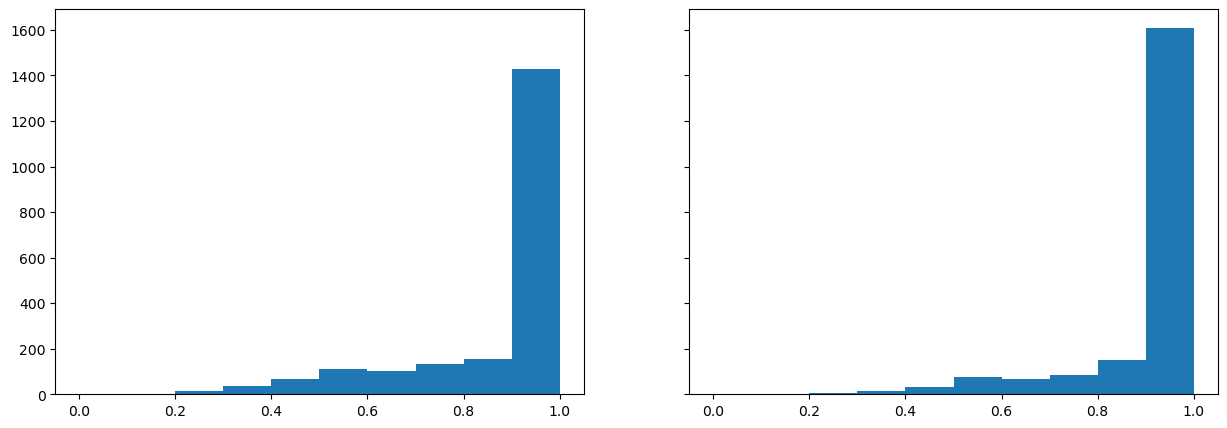

In [43]:
# Creating histogram
fig, ax = plt.subplots(1, 2, figsize =(15, 5), sharey=True)
ax[0].hist(df['openvino_action.probability'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].hist(df['tf_action.probability'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

In [70]:
ov_a_c = pd.DataFrame(df['openvino_action.action'].value_counts(sort = False))
tf_a_c = pd.DataFrame(df['tf_action.action'].value_counts(sort = False))
a_c = ov_a_c.merge(tf_a_c, left_index=True, right_index=True).sort_index()
a_c.index.name='action'
a_c.rename(columns = {'tf_action.action':'tf', 'openvino_action.action': 'openvino'}, inplace = True)
display(a_c)

,openvino,tf
action,,
0,71,68
1,90,80
2,14,50
3,140,258
4,50,53
5,178,131
6,43,67
7,116,41
8,32,122


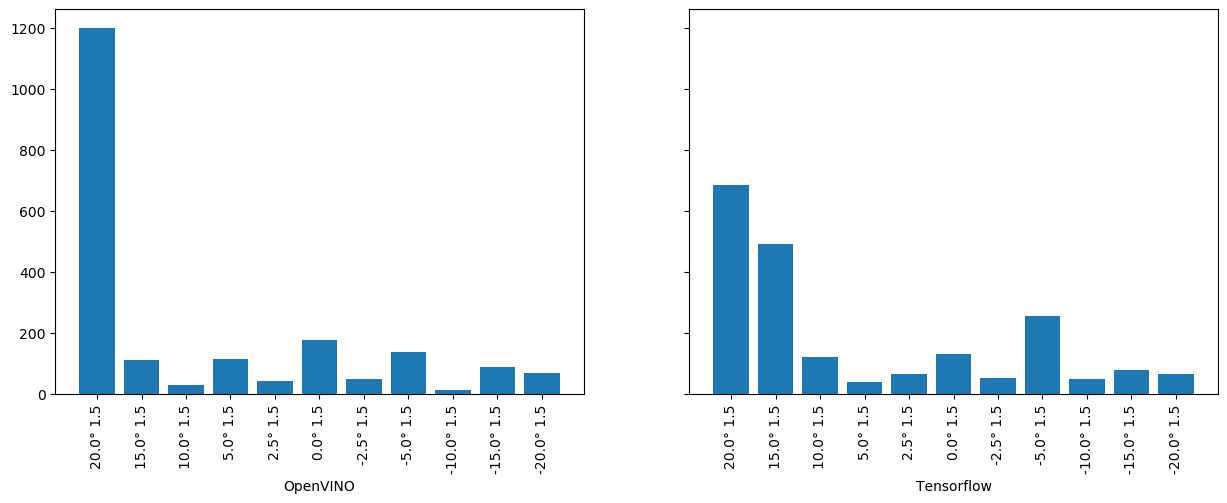

In [83]:
fig, ax = plt.subplots(1, 2, figsize =(15, 5), sharey=True)
fig.lab
ax[0].bar(a_c.index,a_c['openvino'][::-1])
plt.setp(ax[0], xlabel="OpenVINO")
plt.sca(ax[0])
plt.xticks(a_c.index,action_names[::-1],rotation='vertical')

ax[1].bar(a_c.index,a_c['tf'][::-1])
plt.setp(ax[1], xlabel="Tensorflow")
plt.sca(ax[1])
plt.xticks(a_c.index,action_names[::-1],rotation='vertical')
plt.show()